In [1]:
# ! pip install ftfy regex tqdm
# ! pip install git+https://github.com/openai/CLIP.git
# ! pip install sentence-transformers
from sentence_transformers import SentenceTransformer
# !pip install faiss-cpu
# !pip install rake-nltk
import torch
import numpy as np 
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.metrics import jaccard_score
from sklearn.feature_extraction.text import CountVectorizer
import faiss
from rake_nltk import Rake
import spacy
%matplotlib inline
from pycocotools.coco import COCO
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
# ! pip install spacy

import spacy

# ! python -m spacy download en_core_web_md

from spacy.lang.en.examples import sentences 
nlp = spacy.load("en_core_web_md")
from sklearn.metrics import ndcg_score, dcg_score

# ! pip install clip
import torch
import clip
from PIL import Image
import os

from torchvision.datasets import CIFAR100
import os
from math import sqrt, pow, exp
from sklearn.metrics import ndcg_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Yuanxuan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Yuanxuan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
coco_annotation_file_path = "C:\\Users\\Yuanxuan\\Desktop\\CS\\CS 260\\annotations\\captions_train2014.json"
coco_caps = COCO(annotation_file=coco_annotation_file_path)
ann_ids = coco_caps.getAnnIds()
#print(f"Number of annotations: {len(ann_ids)}")

all = {}
for i in ann_ids:
#   #coco_caps.showAnns(anns)
    cap = coco_caps.loadAnns(i)[0].get('caption')
    id = coco_caps.loadAnns(i)[0].get('image_id')
    if id not in all:
         all[id] = cap
    else:
         all[id] += cap
    
# all

# all1 = {}
# for i in ann_ids:
#     #coco_caps.showAnns(anns)
#     #cap = coco_caps.loadAnns(i)[0].get('caption')
#     id = coco_caps.loadAnns(i)[0].get('image_id')
#     all1[id] =  " ".join(get_keywords_ntlk(id))
# all1

all1 = {}
for i in ann_ids:
    #coco_caps.showAnns(anns)
    cap = coco_caps.loadAnns(i)[0].get('caption')
    id = coco_caps.loadAnns(i)[0].get('image_id')
   
    all1[id] = cap

loading annotations into memory...
Done (t=0.48s)
creating index...
index created!


In [3]:
# Get the list of all files and directories
path = "C://Users/Yuanxuan/Desktop/val2014/val2014"

dir_list = os.listdir(path)

# print(dir_list)
def get_id(x):
    return int(x[x.rindex('_')+1:x.rindex('.jpg')])

In [4]:
coco_annotation_file_path_v = "C:\\Users\\Yuanxuan\\Desktop\\CS\\CS 260\\annotations\\captions_val2014.json"
coco_inst_v=COCO('C:\\Users\\Yuanxuan\\Desktop\\CS\\CS 260\\annotations\\instances_val2014.json')

coco_caps_v = COCO(annotation_file=coco_annotation_file_path_v)
ann_ids_v = coco_caps_v.getAnnIds()
#print(f"Number of annotations: {len(ann_ids)}")

all_v = {}
for i in ann_ids_v:
#   #coco_caps.showAnns(anns)
    cap = coco_caps_v.loadAnns(i)[0].get('caption')
    id = coco_caps_v.loadAnns(i)[0].get('image_id')
    if id not in all_v:
         all_v[id] = cap
    else:
         all_v[id] += " " + cap

loading annotations into memory...
Done (t=4.28s)
creating index...
index created!
loading annotations into memory...
Done (t=0.23s)
creating index...
index created!


In [5]:
def squared_sum(x):
  """ return 3 rounded square rooted value """
 
  return round(sqrt(sum([a*a for a in x])),3)

def cos_similarity(x,y):
  """ return cosine similarity between two lists """
 
  numerator = sum(a*b for a,b in zip(x,y))
  denominator = squared_sum(x)*squared_sum(y)
  return round(numerator/float(denominator),3)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [7]:
path_of_the_directory= "C://Users/Yuanxuan/Desktop/val2014/val2014"
text_features = torch.load('C:\\Users\\Yuanxuan\\Desktop\\CS\\CS 260\\annotations\\tensor.pt')
text_features /= text_features.norm(dim=-1, keepdim=True)
coco_inst=COCO('C:\\Users\\Yuanxuan\\Desktop\\CS\\CS 260\\annotations\\instances_train2014.json')

loading annotations into memory...
Done (t=8.41s)
creating index...
index created!


In [8]:
emb1 = []
for j in range(len(dir_list[0:100])):
    filename = dir_list[j]
    cap_input = all_v[get_id(filename)]
    sentences = [cap_input]
    embedding1 = [nlp(sentence).vector for sentence in sentences]
    emb1.append(embedding1)

In [9]:
emb2 = []
res = list(all.keys())
for j in range(len(res)):
    sentences = [all1[res[j]]]
    embedding2 = [nlp(sentence).vector for sentence in sentences]
    emb2.append(embedding2)

In [14]:
relevant_count_list=[]
thislist = []
for j in range(len(dir_list[0:100])):

        filename = dir_list[j]

    #     path_of_the_directory= "C://Users/Yuanxuan/Desktop/val2014/val2014"
        f = os.path.join(path_of_the_directory,filename)
        image_input = preprocess(Image.open(f)).unsqueeze(0).to(device)

        with torch.no_grad():
            image_features = model.encode_image(image_input)


        torch.cuda.empty_cache()
    #     text_features = torch.load('C:\\Users\\Yuanxuan\\Desktop\\CS\\CS 260\\annotations\\tensor.pt')

        image_features /= image_features.norm(dim=-1, keepdim=True)
    #     text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

        k1 = 82783
        values, indices = similarity[0].topk(k1)

    #     coco_inst=COCO('C:\\Users\\Yuanxuan\\Desktop\\CS\\CS 260\\annotations\\instances_train2014.json')
    #     res = list(all.keys())

        result_index = list()
        for i in range(k1):
            result_index.append(indices[i].item())

    #     cap_input = all_v[get_id(filename)]

        k = 100
        thislist1 = []
        relevant_count = 0
        for i in result_index[0:k]:
    #         id = res[i]
    #         cap_output = all1[id]
    #         sentences = [cap_output]
    #         embedding2 = [nlp(sentence).vector for sentence in sentences]
            s = cos_similarity(emb1[j][0], emb2[i][0])
            thislist1.append(s)
            if (s >= 0.8):
                relevant_count += 1
        relevant_count_list.append(relevant_count)
        thislist.append(thislist1)

In [15]:
def Average(lst):
    return sum(lst) / len(lst)

In [16]:
# Calculate NDCG Score
ndcg_score_list = []
for i in range(len(thislist)):

    ideal_order = thislist[i]
    ideal_order.sort(reverse=True)
    
    scores = np.asarray([ideal_order])
    
    true_relevance = np.asarray([thislist[i]])

    ndcg = ndcg_score(true_relevance, scores)
  
    ndcg_score_list.append(ndcg)

# print(ndcg_score_list)
print(Average(ndcg_score_list))

1.0000000000000002


In [23]:
# Precision at k: relevent item / k
precision_k_list = []
for j in range(len(dir_list[0:99])):
    precision_k = relevant_count_list[j]/k
    precision_k_list.append(precision_k)
    # print("Precision at k: " + str(precision_k))
print(Average(precision_k_list))

0.2827272727272727


In [18]:
relevant_count1_list = []
# Find all False (false_postive and false_negative)
for j in range(len(dir_list[0:99])):
    filename = dir_list[j]
#     path_of_the_directory= "C://Users/Yuanxuan/Desktop/val2014/val2014"
    f = os.path.join(path_of_the_directory,filename)
    image_input = preprocess(Image.open(f)).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image_input)


    torch.cuda.empty_cache()
#     text_features = torch.load('C:\\Users\\Yuanxuan\\Desktop\\CS\\CS 260\\annotations\\tensor.pt')

    image_features /= image_features.norm(dim=-1, keepdim=True)
#     text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    
    k1 = 82783
    values, indices = similarity[0].topk(k1)

#     coco_inst=COCO('C:\\Users\\Yuanxuan\\Desktop\\CS\\CS 260\\annotations\\instances_train2014.json')
    res = list(all.keys())

    result_index = list()
    for i in range(k1):
        result_index.append(indices[i].item())
    
    cap_input = all_v[get_id(filename)]
    
    k = 100
    k2 = 1000
    relevant_count1 = 0
    for i in result_index[k:k2]:
        s = cos_similarity(emb1[j][0], emb2[i][0])       
        if (s >= 0.8):
            relevant_count1 += 1
    relevant_count1_list.append(relevant_count1)

In [19]:
# Prevision, Recall, and F1 Score
# TP = True Positive，TN = True Negative，FP = False Positive，FN = False Negative
p_list = []
r_list = []
f1_list =[]
for i in range(len(dir_list[0:99])):
    TP = relevant_count_list[i]
    TN = k-relevant_count_list[i]
    FP = relevant_count1_list[i]
    FN = k1-k-relevant_count1_list[i]
    # print(TP)
    # print(TN)
    # print(FP)
    # print(FN)
    p = TP / (TP + FP)
    r = TP / (TP + FN)
    f1 = 2 * p * r / (p + r)
    p_list.append(p)
    r_list.append(r)
    f1_list.append(f1)
    # print("Precision score: " + str(p))
    # print("Recall score: " + str(r))
    # print("F1 score: " + str(f1))
print("Precision score: " + str(Average(p_list)))
print("Recall score:: " + str(Average(r_list)))
print("F1 score: " + str(Average(f1_list)))

Precision score: 0.10575103817424547
Recall score:: 0.0009829020831268647
F1 score: 0.0019473522176216874


# plot in different criterion

In [20]:
"""In different relevant criterion """
relevant_score = [0.5, 0.6, 0.7, 0.8, 0.9]
relevant_score = [0.5, 0.6, 0.7, 0.8, 0.9]
relevant_count_final = []
final_list = []
for m in relevant_score:
    thislist = []
    relevant_count_list = []

    for j in range(len(dir_list[0:100])):

        filename = dir_list[j]

    #     path_of_the_directory= "C://Users/Yuanxuan/Desktop/val2014/val2014"
        f = os.path.join(path_of_the_directory,filename)
        image_input = preprocess(Image.open(f)).unsqueeze(0).to(device)

        with torch.no_grad():
            image_features = model.encode_image(image_input)


        torch.cuda.empty_cache()
    #     text_features = torch.load('C:\\Users\\Yuanxuan\\Desktop\\CS\\CS 260\\annotations\\tensor.pt')

        image_features /= image_features.norm(dim=-1, keepdim=True)
    #     text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

        k1 = 82783
        values, indices = similarity[0].topk(k1)

    #     coco_inst=COCO('C:\\Users\\Yuanxuan\\Desktop\\CS\\CS 260\\annotations\\instances_train2014.json')
    #     res = list(all.keys())

        result_index = list()
        for i in range(k1):
            result_index.append(indices[i].item())

    #     cap_input = all_v[get_id(filename)]

        k = 100
        thislist1 = []
        relevant_count = 0
        for i in result_index[0:k]:
            s = cos_similarity(emb1[j][0], emb2[i][0])
            thislist1.append(s)
            if (s >= m):
                relevant_count += 1
        relevant_count_list.append(relevant_count)
        thislist.append(thislist1)
    relevant_count_final.append(relevant_count_list)
    final_list.append(thislist)

In [21]:
ave_relevant_count_final = []
for i in range(len(relevant_count_final)):
    average = Average(relevant_count_final[i])
    ave_relevant_count_final.append(average)

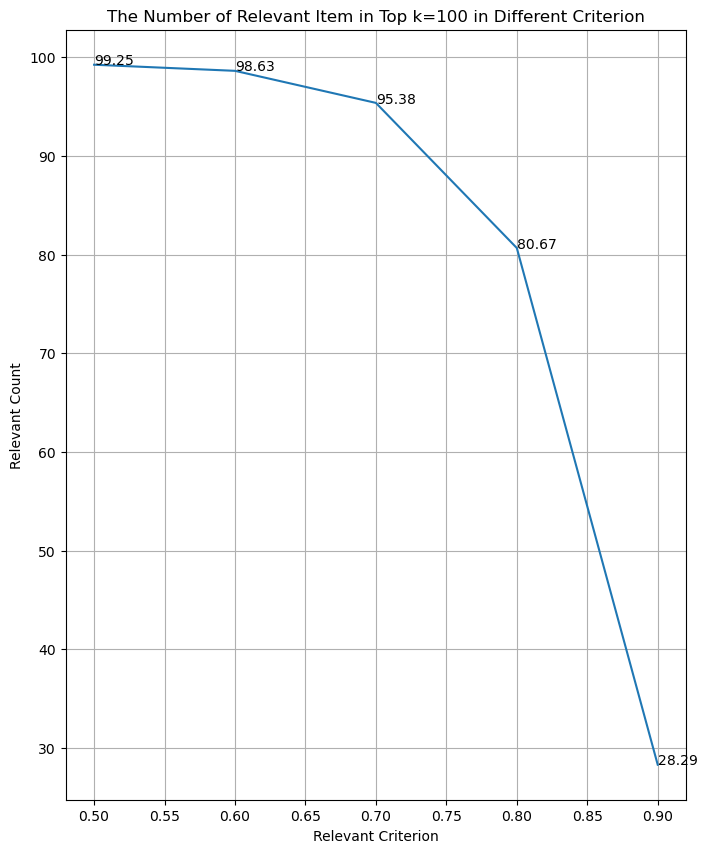

In [24]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
x = np.array(relevant_score)
y = np.array(ave_relevant_count_final)


fig = pyplot.figure()
ax = fig.add_subplot(111)
plt.plot(relevant_score, ave_relevant_count_final)
plt.ylabel('Relevant Count')
plt.xlabel('Relevant Criterion')
plt.title('The Number of Relevant Item in Top k=100 in Different Criterion')
for i,j in zip(x,y):
    ax.annotate(str(j),xy=(i,j))
plt.grid(True)
plt.show()

In [25]:
# Precision at k: relevent item / k
final_p = []
for i in range(len(relevant_score)):
    precision_k_list = []
    for j in range(len(dir_list[0:100])):
        precision_k = relevant_count_final[i][j]/k
        precision_k_list.append(precision_k)
        # print("Precision at k: " + str(precision_k))
    final_p.append(Average(precision_k_list))

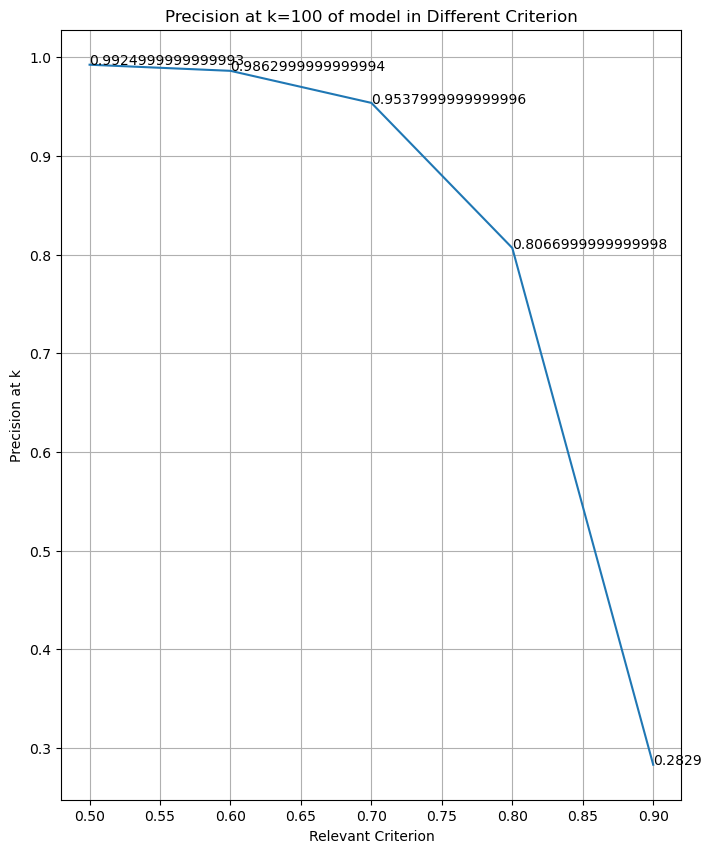

In [27]:
x = np.array(relevant_score)
y = np.array(final_p)


fig = pyplot.figure()
ax = fig.add_subplot(111)
plt.plot(relevant_score, final_p)
plt.ylabel('Precision at k')
plt.xlabel('Relevant Criterion')
plt.title('Precision at k=100 of model in Different Criterion')
for i,j in zip(x,y):
    ax.annotate(str(j),xy=(i,j))
plt.grid(True)
plt.show()

In [28]:
"""In different k criterion at 0.8 relvent criterion"""
different_k = [10, 50, 75, 100]
relevant_count_final = []
final_list = []
for m in different_k:
    thislist = []
    relevant_count_list = []

    for j in range(len(dir_list[0:100])):

        filename = dir_list[j]

    #     path_of_the_directory= "C://Users/Yuanxuan/Desktop/val2014/val2014"
        f = os.path.join(path_of_the_directory,filename)
        image_input = preprocess(Image.open(f)).unsqueeze(0).to(device)

        with torch.no_grad():
            image_features = model.encode_image(image_input)


        torch.cuda.empty_cache()
    #     text_features = torch.load('C:\\Users\\Yuanxuan\\Desktop\\CS\\CS 260\\annotations\\tensor.pt')

        image_features /= image_features.norm(dim=-1, keepdim=True)
    #     text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

        k1 = 82783
        values, indices = similarity[0].topk(k1)

    #     coco_inst=COCO('C:\\Users\\Yuanxuan\\Desktop\\CS\\CS 260\\annotations\\instances_train2014.json')
    #     res = list(all.keys())

        result_index = list()
        for i in range(k1):
            result_index.append(indices[i].item())

    #     cap_input = all_v[get_id(filename)]

        k = m
        thislist1 = []
        relevant_count = 0
        for i in result_index[0:k]:
            s = cos_similarity(emb1[j][0], emb2[i][0])
            thislist1.append(s)
            if (s >= 0.8):
                relevant_count += 1
        relevant_count_list.append(relevant_count)
        thislist.append(thislist1)
    relevant_count_final.append(relevant_count_list)
    final_list.append(thislist)

In [29]:
ave_relevant_count_final = []
for i in range(len(relevant_count_final)):
    average = Average(relevant_count_final[i])
    ave_relevant_count_final.append(average)

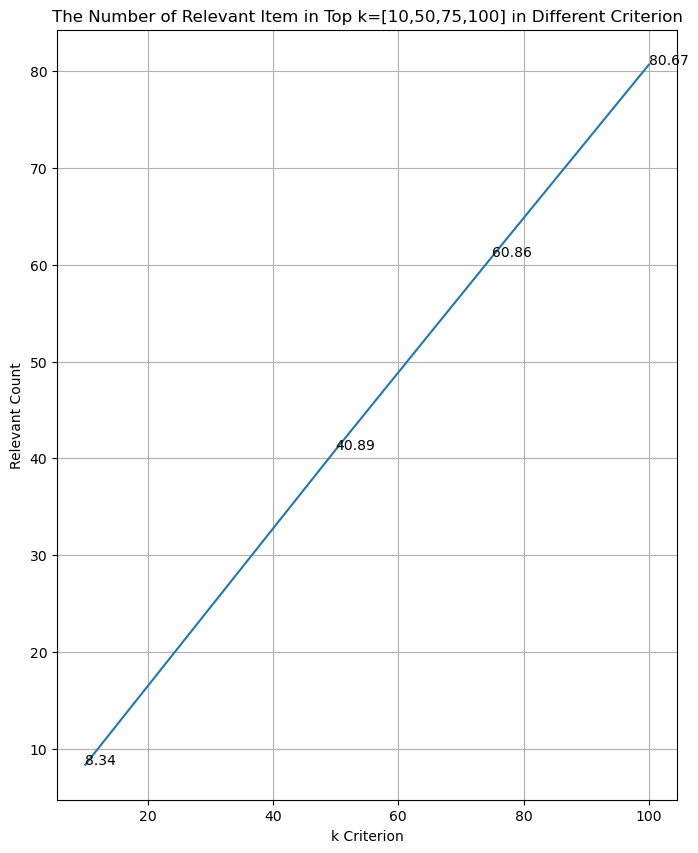

In [31]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
x = np.array(different_k)
y = np.array(ave_relevant_count_final)


fig = pyplot.figure()
ax = fig.add_subplot(111)
plt.plot(different_k, ave_relevant_count_final)
plt.ylabel('Relevant Count')
plt.xlabel('k Criterion')
plt.title('The Number of Relevant Item in Top k=[10,50,75,100] in Different Criterion')
for i,j in zip(x,y):
    ax.annotate(str(j),xy=(i,j))
plt.grid(True)
plt.show()

In [32]:
# Precision at k: relevent item / k
final_p = []
for i in range(len(different_k)):
    precision_k_list = []
    for j in range(len(dir_list[0:100])):
        precision_k = relevant_count_final[i][j]/different_k[i]
        precision_k_list.append(precision_k)
        # print("Precision at k: " + str(precision_k))
    final_p.append(Average(precision_k_list))

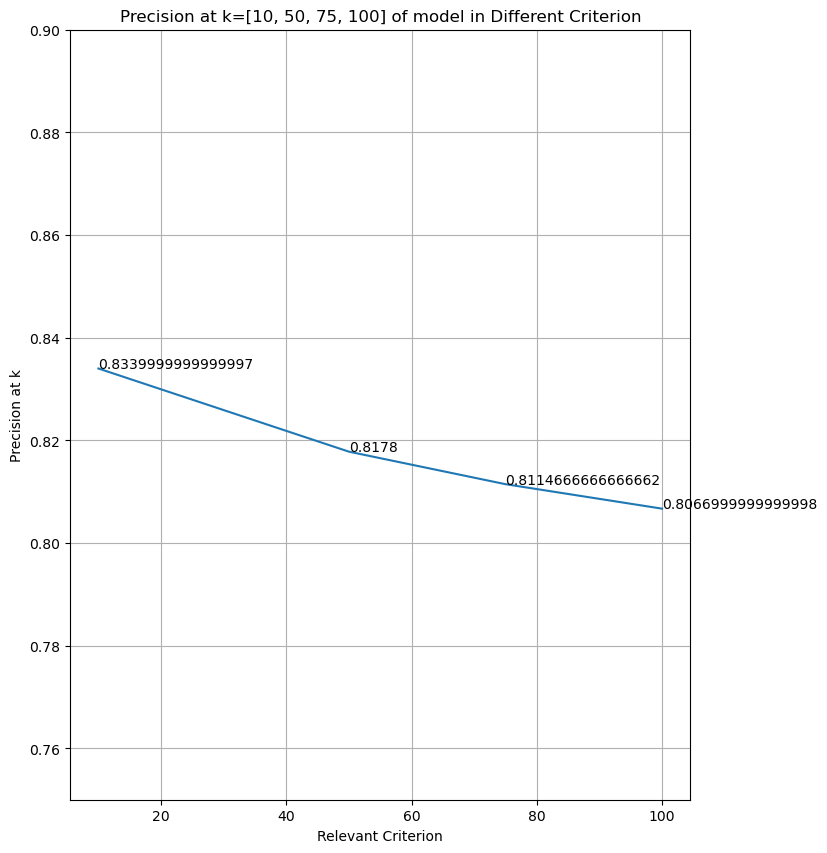

In [38]:
x = np.array(different_k)
y = np.array(final_p)


fig = pyplot.figure()
ax = fig.add_subplot(111)
plt.plot(different_k, final_p)
ax.set_ylim(.75,.9)
plt.ylabel('Precision at k')
plt.xlabel('Relevant Criterion')
plt.title('Precision at k=[10, 50, 75, 100] of model in Different Criterion')
for i,j in zip(x,y):
    ax.annotate(str(j),xy=(i,j))
plt.grid(True)
plt.show()